# BRIL algorithm applied to eye-tracking calibration

<br>
This notebook presents the application of the BRIL algorithm to real-world datasets, as complementary material of the article : <br>
<i>Brilhault A, Neuenschwander S, Rios RA, "A New Robust Multivariate Mode Estimator for Eye-tracking Calibration", 2021, Behavior Research Methods (submitted)</i>

The data consists of eye-tracking calibrations recorded in the context of visual studies in capuchins (carried out at the Brain Institute of the Federal University of Rio Grande de Norte, Brazil). Eye positions were recorded using the eye-tracking setup developed by [Matsuda Keiji et al.](https://staff.aist.go.jp/k.matsuda/iRecHS2/index_e.html). The system relies on a PointGrey Grasshopper3 infrared camera (GS3-U3-41C6NIR-C). Image acquisition was set at a frequency of 235Hz. The eye coordinate signals generated by the system were recorded through an acquisition board (National Instruments E-Series board), at a sampling frequency of 1000 samples/s.

We demonstrate the robustness of our algorithm, BRIL, in estimating the reference coordinates for each calibration target despite the highly contaminated data resulting from the subjects lack of attention or cooperation. Note that the three datasets presented in the article as *Set1*, *Set2*, and *Set3* (with low, medium, and high contamination) correspond to the sessions *juj011a00*,
*ded00800*, and *ded005a01*, respectivly.

To run this notebook interactively, follow the link below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/adrienbrilhault/BRIL/HEAD?filepath=demo_EyeTrackingData.ipynb)



## Requirements

The following R packages are required for the execution of the notebook:

* [tidyverse](https://www.tidyverse.org/) (install using the command `install.package("tidyverse")`)
* [BRIL](https://github.com/adrienbrilhault/BRIL) (first install the package [remotes](https://github.com/r-lib/remotes) if missing: `install.package("remotes")`, then the BRIL package with `remotes::install_github("adrienbrilhault/BRIL", subdir = "pkg")`)


## Libraries and dataset loading

The horizontal and vertical eye-positions recorded during the calibrations are stored in the variables `x` and `y`, respectively. Each consist of a matrix, rows corresponding to single trials, and columns to the successive measurements within the trials (1 per millisecond, since the data was acquired at 1000hz). `Metadata`, having the same number of rows, contains the information relative to each trial in `x` and `y`, namely the session, trial number, target presented, total the number of trials and targets for the corresponding session, as well as the durations of the recording (in ms). Note that as the duration varies from a session to another, the tables `x` and `y` were filled with `NA` until the end of the rows in shorter trials.

In [1]:
# Load libraries
suppressPackageStartupMessages(library(BRIL))
suppressPackageStartupMessages(library(tidyverse))

## Load data
rm(list=ls())
#load("Data/eyeTrackingCalibrations.Rdata")
load(gzcon(url('https://github.com/adrienbrilhault/BRIL/raw/master/data/eyeTrackingCalibrations.Rdata')))

## Print preview of the data
cat("Variables:\n")
print(ls())
cat("\nmetadata: ", class(metadata), "(", typeof(metadata), "), dim", dim(metadata), " \n")
print(metadata[1:5, ])
cat("\nSessions: \n")
print(sort(unique(metadata$session)))
cat("\nx: ", class(x), "(", typeof(x), "), dim", dim(x), " \n")
print(x[0:10])
cat("\ny: ", class(y), "(", typeof(y), "), dim", dim(y), " \n")
print(y[0:10])

Variables:
[1] "groundTruth" "metadata"    "x"           "y"          

metadata:  data.frame ( list ), dim 240 6  
    session trial nTrials duration target nTargets
1 ded005a01     1      50     3000      4        5
2 ded005a01     2      50     3000      2        5
3 ded005a01     3      50     3000      5        5
4 ded005a01     4      50     3000      2        5
5 ded005a01     5      50     3000      4        5

Sessions: 
[1] "ded005a01" "ded006a00" "ded00800"  "juj00300"  "juj011a00"

x:  matrix array ( integer ), dim 240 3000  
 [1]  14199  21703  22505  22514  17203  18172  22400  21573 -32768  20824

y:  matrix array ( integer ), dim 240 3000  
 [1]  -2467 -10002   1037  -9699  -6936    607    834  -9940 -32768  -8358


## Summary statistics

Since one calibration point is drawn randomly within the 5 calibration targets at each trial, the number of trials per target within one session may vary. The table below shows the characteristics of each session, with the number of samples collected for each of the targets, as well as the number of valid samples, once incorrect positions have been filtered out (these being the result of eye blinks, artifacts, or saturated values from the analog acquisition board).


In [2]:
summary <- metadata %>%
  select(session, duration, nTrials, nTargets, target) %>%
  arrange(session, target) %>%
  distinct_all()

summary$nTrialsTarget <- NA
summary$nSamples <- NA
summary$nValidSamples <- NA

for (i in 1:nrow(summary)) {
  selectedIndices <- metadata$session == summary$session[i] &
    metadata$target == summary$target[i]

  df <- data.frame(
    X = as.vector(t(x[selectedIndices, ])),
    Y = as.vector(t(y[selectedIndices, ]))
  )

  # Remove trailing NA fill
  df <- df[!is.na(df$X) | !is.na(df$Y), ]
  summary$nSamples[i] <- nrow(df)
  # Remove overflowed values and error codes from eyetracker
  df <- df[df$X != -32768 & df$Y != -32768, ]
  df <- df[df$X != 32767 & df$Y != 32767, ]

  summary$nTrialsTarget[i] <- sum(selectedIndices)
  summary$nValidSamples[i] <- nrow(df)
}
rownames(summary) <- NULL
colnames(summary) <- c(
  "Session", "Duration", "TotalTrials", "TotalTargets",
  "Target", "TargetTrials", "Samples", "ValidSamples"
)

data.frame(summary)

Session,Duration,TotalTrials,TotalTargets,Target,TargetTrials,Samples,ValidSamples
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ded005a01,3000,50,5,1,6,18000,15607
ded005a01,3000,50,5,2,8,24000,21318
ded005a01,3000,50,5,3,10,30000,26602
ded005a01,3000,50,5,4,19,57000,46419
ded005a01,3000,50,5,5,7,21000,18536
ded006a00,2200,40,5,1,9,19800,16047
ded006a00,2200,40,5,2,4,8800,7353
ded006a00,2200,40,5,3,8,17600,14841
ded006a00,2200,40,5,4,8,17600,14875


## Filter data for a given session and target

Process one sample distribution, pooling all the trials for a specific session and target. Filter the incorrect sample, then apply the BRIL algorithm to estimate the main mode.


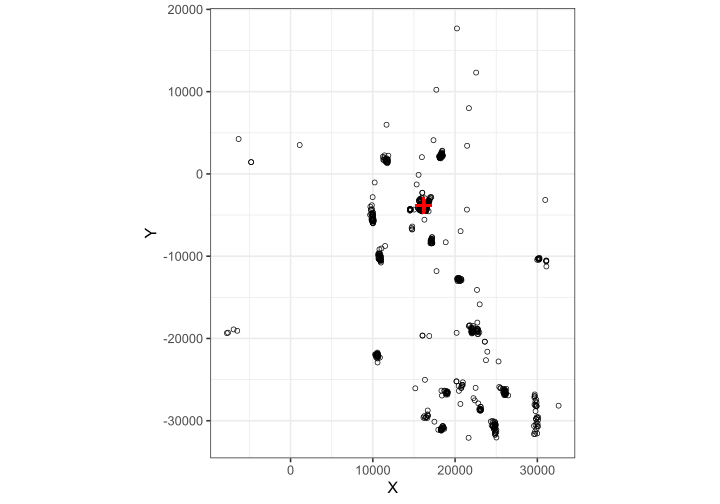

In [3]:
set.seed(123)

# Select a session and target number
session <- "ded005a01"
target <- 1

# Filter the corresponding trials
selectedIndices <- metadata$session == session & metadata$target == target
df <- data.frame(
  X = as.vector(t(x[selectedIndices, ])),
  Y = as.vector(t(y[selectedIndices, ]))
)

# Remove trailing NA fill
df <- df[!is.na(df$X) | !is.na(df$Y), ]

# Remove overflowed values and error codes from eyetracker
df <- df[df$X != -32768 & df$Y != -32768, ]
df <- df[df$X != 32767 & df$Y != 32767, ]

# Draw 1000 random samples and estimate the mode with the BRIL method
df <- sample_n(df, 1000)
res <- bril(df, method = "Projection", testNormal = "Mardia", maxIterations = 5)

# Plot the result
options(jupyter.plot_mimetypes = "image/svg+xml")
theme_set(theme_bw(base_size = 16))
options(repr.plot.width = 10, repr.plot.height = 7)

ggplot(df, aes(x = X, y = Y)) +
  geom_point(size = 2, shape = 1) +
  geom_point(aes(x = res$mode[1], y = res$mode[2]),
    colour = "red",
    shape = 3, size = 3, stroke = 2
  ) +
  coord_fixed(ratio = 1, expand = TRUE)

## Process a complete calibration procedure

Apply the same procedure as above for each of the targets of one or several sessions, plotting the final result with each sample displayed in a color corresponding to the target that was presented at the time of the recording.


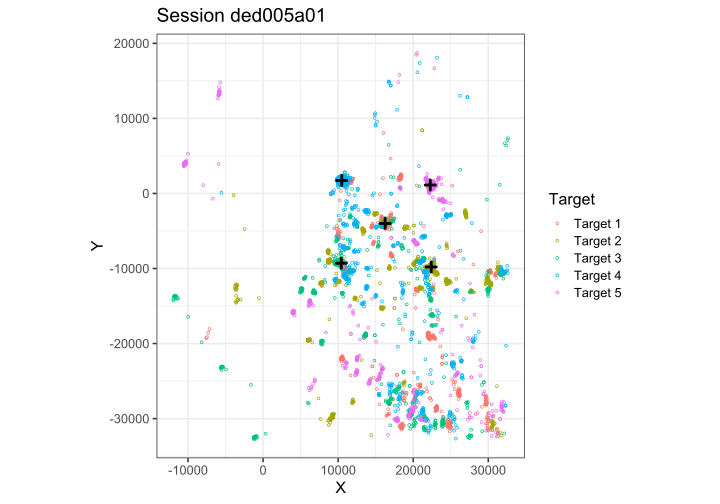

In [5]:
# Select one or several sessions to process
sessions <- c("ded005a01")

# Analyze each session
for (session in sessions) {
  dfCalibration <- data.frame()
  dfModes <- c()

  # Iterate through each target within the session
  for (target in sort(unique(metadata$target[metadata$session == session]))) {

    # Filter the corresponding trials
    selectedIndices <- metadata$session == session & metadata$target == target
    df <- data.frame(
      X = as.vector(t(x[selectedIndices, ])),
      Y = as.vector(t(y[selectedIndices, ]))
    )

    # Remove trailing NA fill
    df <- df[!is.na(df$X) | !is.na(df$Y), ]

    # Remove overflowed values and error codes from eye-tracker
    df <- df[df$X != -32768 & df$Y != -32768, ]
    df <- df[df$X != 32767 & df$Y != 32767, ]

    # Draw 1000 random samples and estimate the mode
    df <- sample_n(df, 1000)
    res <- bril(df, method = "L2", testNormal = "Mardia", maxIterations = 5)

    # Update structures
    df$Target <- paste("Target", target)
    dfCalibration <- rbind(dfCalibration, df)
    dfModes <- rbind(dfModes, res$mode)
  }

  # Plot samples and mode
  dfModes <- data.frame(dfModes)
  colnames(dfModes) <- c("X", "Y")
  rownames(dfModes) <- NULL

  g <- ggplot(dfCalibration, aes(x = X, y = Y, color = Target)) +
    geom_point(size = 1, shape = 1) +
    geom_point(
      data = dfModes, aes(x = X, y = Y),
      colour = "black", shape = 3, size = 2, stroke = 2
    ) +
    coord_fixed(ratio = 1, expand = TRUE) +
    ggtitle(paste("Session",session))
  print(g)

  # save image
  if (FALSE) {
    ggsave(g, filename = paste0("calibration_", session, ".jpg"), width = 7, height = 6)
  }
}